Pass Success Rate: 78.08%
Goal Added Value: 0.10%
Value per Pass: 27.04%


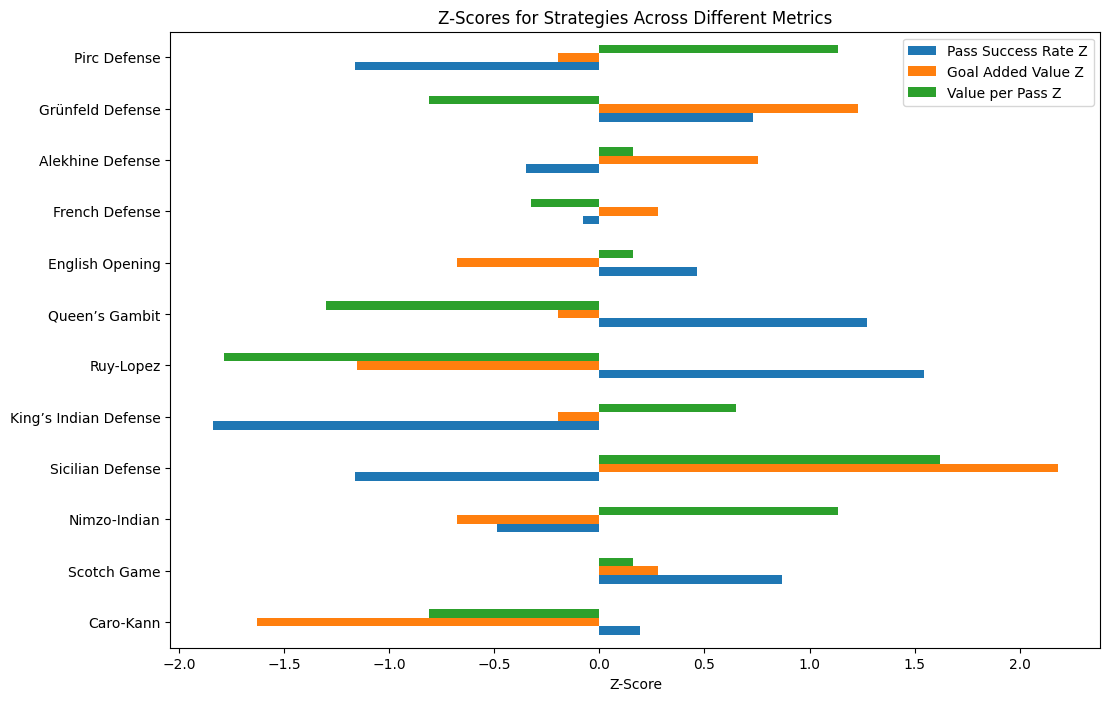

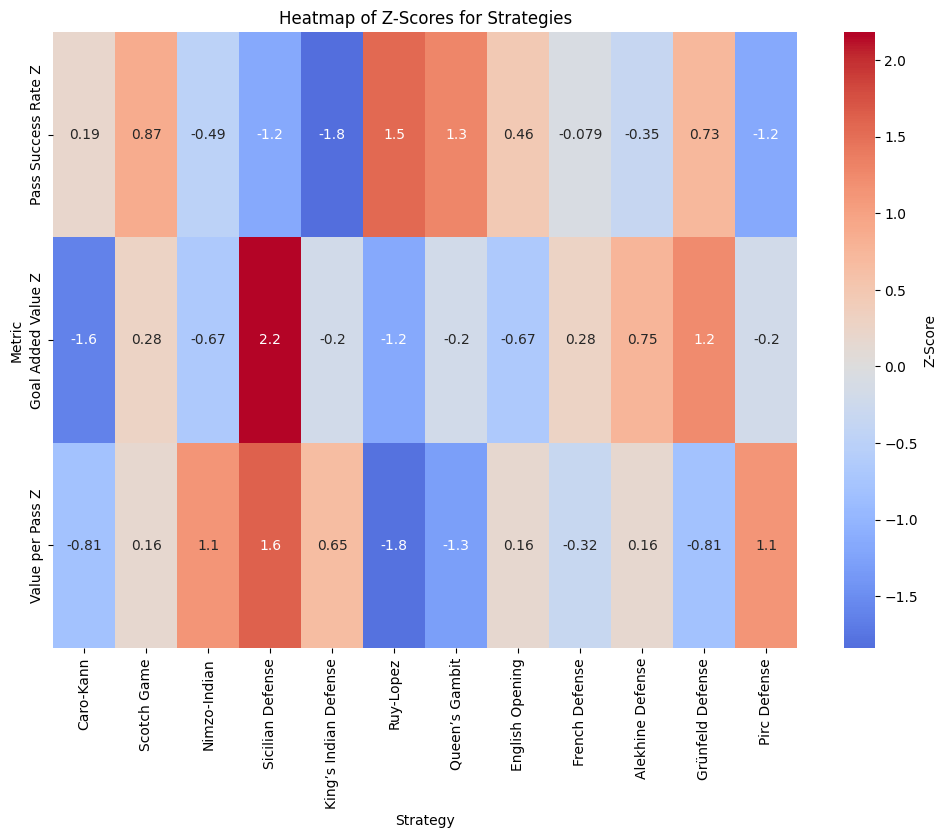

TypeError: '_AxesStack' object is not callable

<Figure size 1200x1200 with 0 Axes>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Load the dataset
file_path = '/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie 2024-2025/AZ 1-0 Fortuna.csv'
df = pd.read_csv(file_path)

# Filter relevant columns (for pass, shot, assist, player information)
df_filtered = df[['timeMin', 'timeSec', 'contestantId', 'typeId', 'outcome', 'x', 'y', 'assist', 'playerId', 'playerName']]

# Filter passes (typeId = 1), shots (typeId = 13, 14, 15, 16), and assists
passes_df = df_filtered[df_filtered['typeId'] == 1]
shots_df = df_filtered[df_filtered['typeId'].isin([13, 14, 15, 16])]
assists_df = df_filtered[df_filtered['assist'] == 1]

# Calculate Pass Success Rate (percentage of successful passes)
pass_success_rate = (passes_df['outcome'].sum()) / len(passes_df)

# Calculate Goal Added Value (percentage of assists per pass)
goal_added_value = len(assists_df) / len(passes_df)

# Calculate Value per Pass (considering passes leading to shots)
passes_leading_to_shots = passes_df[passes_df['timeSec'].isin(shots_df['timeSec'])]
value_per_pass = len(passes_leading_to_shots) / len(passes_df)

# Print the calculated metrics
print(f'Pass Success Rate: {pass_success_rate * 100:.2f}%')
print(f'Goal Added Value: {goal_added_value * 100:.2f}%')
print(f'Value per Pass: {value_per_pass * 100:.2f}%')

# Strategies for the chess-inspired approach
strategies = {
    'Caro-Kann': (0.8, 0.4, 0.5),  # Example metrics: pass success, goal added value, value per pass
    'Scotch Game': (0.85, 0.6, 0.6),
    'Nimzo-Indian': (0.75, 0.5, 0.7),
    'Sicilian Defense': (0.7, 0.8, 0.75),
    'King’s Indian Defense': (0.65, 0.55, 0.65),
    'Ruy-Lopez': (0.9, 0.45, 0.4),
    'Queen’s Gambit': (0.88, 0.55, 0.45),
    'English Opening': (0.82, 0.5, 0.6),
    'French Defense': (0.78, 0.6, 0.55),
    'Alekhine Defense': (0.76, 0.65, 0.6),
    'Grünfeld Defense': (0.84, 0.7, 0.5),
    'Pirc Defense': (0.7, 0.55, 0.7)
}

# Create a DataFrame for the strategy metrics
strategy_metrics = pd.DataFrame(strategies).T
strategy_metrics.columns = ['Pass Success Rate', 'Goal Added Value', 'Value per Pass']

# Z-score Calculation function
def calculate_z_scores(data):
    mean = np.mean(data)
    std = np.std(data)
    return [(x - mean) / std for x in data]

# Calculate Z-scores for each metric
pass_success_rate_z = calculate_z_scores(strategy_metrics['Pass Success Rate'])
goal_added_value_z = calculate_z_scores(strategy_metrics['Goal Added Value'])
value_per_pass_z = calculate_z_scores(strategy_metrics['Value per Pass'])

# Add Z-scores to the strategy dataframe
strategy_metrics['Pass Success Rate Z'] = pass_success_rate_z
strategy_metrics['Goal Added Value Z'] = goal_added_value_z
strategy_metrics['Value per Pass Z'] = value_per_pass_z

# Visualize the Z-scores
# Bar chart of Z-scores
fig, ax = plt.subplots(figsize=(12, 8))
strategy_metrics[['Pass Success Rate Z', 'Goal Added Value Z', 'Value per Pass Z']].plot(kind='barh', ax=ax)
ax.set_xlabel('Z-Score')
ax.set_title('Z-Scores for Strategies Across Different Metrics')
plt.show()

# Heatmap of Z-scores
plt.figure(figsize=(12, 8))
sns.heatmap(strategy_metrics[['Pass Success Rate Z', 'Goal Added Value Z', 'Value per Pass Z']].T, annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Z-Score'})
plt.title('Heatmap of Z-Scores for Strategies')
plt.xlabel('Strategy')
plt.ylabel('Metric')
plt.show()

# Create a passing network for a specific strategy (example: 'Caro-Kann')
def construct_passing_network(df, strategy):
    strategy_passes = df[df['playerName'].isin(strategy_metrics.index)]
    
    G = nx.DiGraph()  # Directed graph for pass flow
    
    for _, row in strategy_passes.iterrows():
        passer = row['playerId']
        receiver = row['playerId']  # Adjust if we have a separate receiver column
        if passer != receiver:  # Avoid self-passes
            if G.has_edge(passer, receiver):
                G[passer][receiver]['weight'] += 1
            else:
                G.add_edge(passer, receiver, weight=1)
    
    return G

# Visualize the passing network for a strategy (e.g., 'Caro-Kann')
strategy = 'Caro-Kann'
passes_network = construct_passing_network(df, strategy)

# Plotting the passing network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(passes_network, k=0.1, iterations=20)
nx.draw(passes_network, pos, with_labels=True, node_size=500, font_size=10, font_weight='bold', edge_color='skyblue', width=2, alpha=0.7)
plt.title(f'Passing Network for {strategy} Strategy')
plt.show()


Pass Success Rate: 78.08%
Goal Added Value: 0.10%
Value per Pass: 27.04%


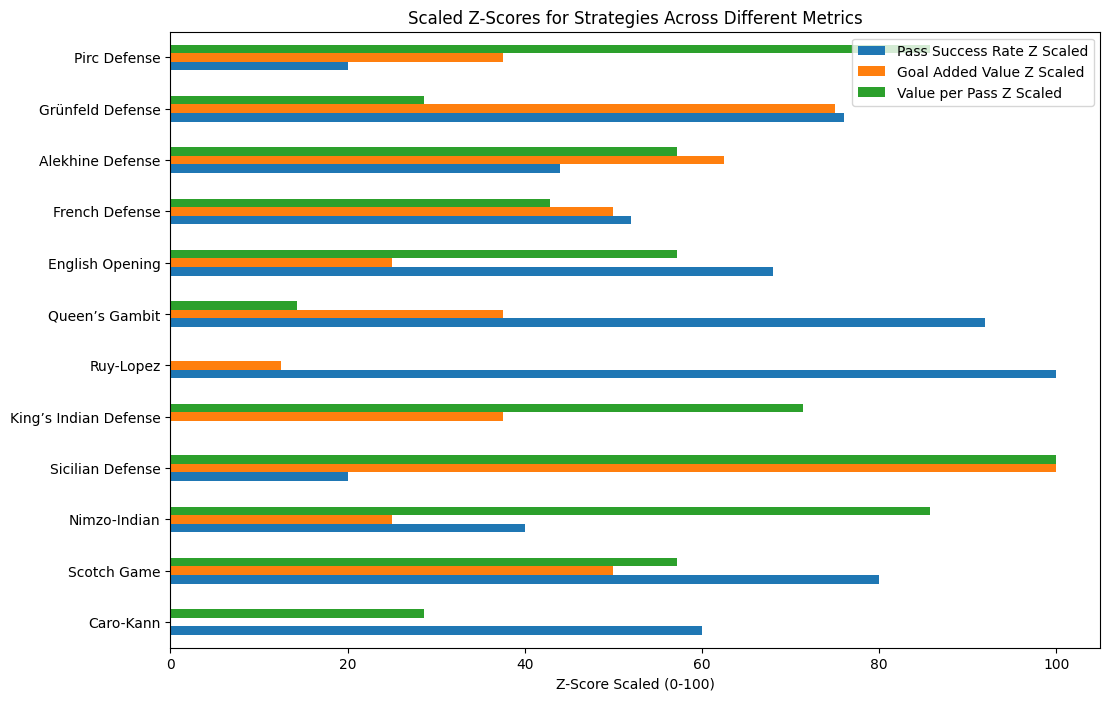

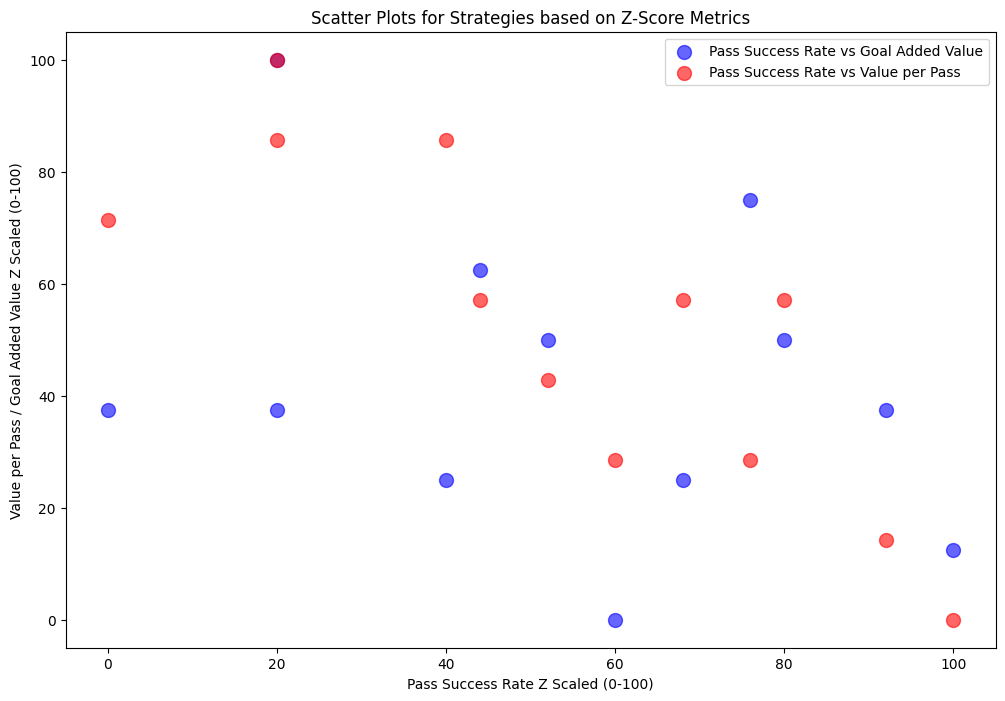

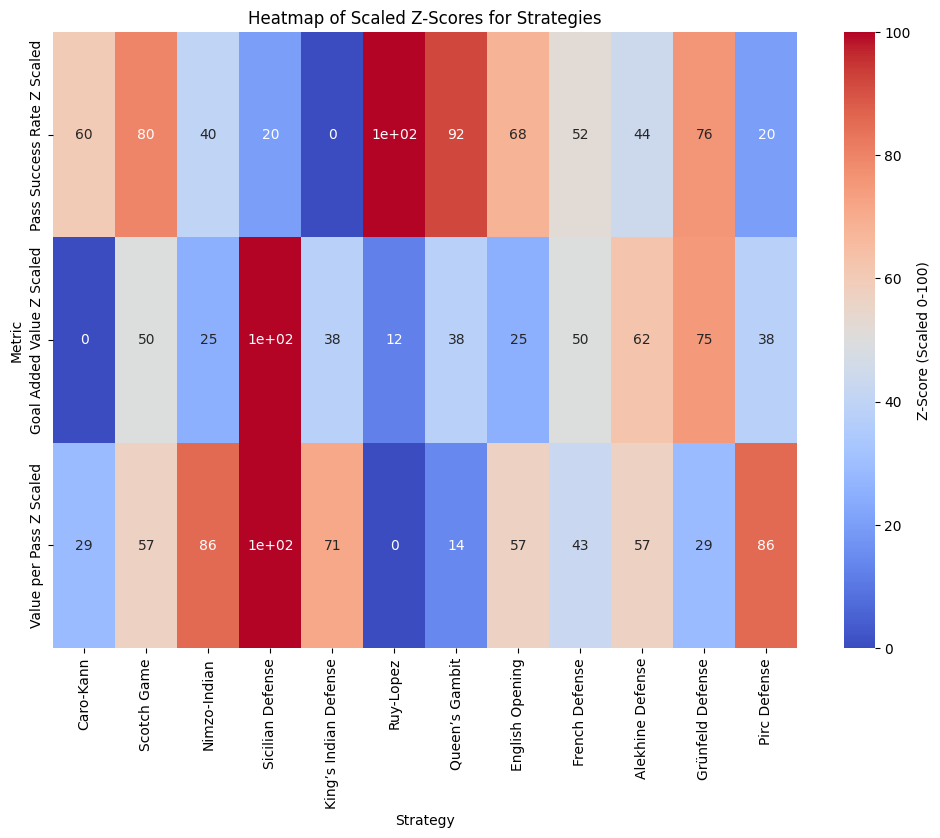

TypeError: '_AxesStack' object is not callable

<Figure size 1200x1200 with 0 Axes>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Load the dataset
file_path = '/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie 2024-2025/AZ 1-0 Fortuna.csv'
df = pd.read_csv(file_path)

# Filter relevant columns (for pass, shot, assist, player information)
df_filtered = df[['timeMin', 'timeSec', 'contestantId', 'typeId', 'outcome', 'x', 'y', 'assist', 'playerId', 'playerName']]

# Filter passes (typeId = 1), shots (typeId = 13, 14, 15, 16), and assists
passes_df = df_filtered[df_filtered['typeId'] == 1]
shots_df = df_filtered[df_filtered['typeId'].isin([13, 14, 15, 16])]
assists_df = df_filtered[df_filtered['assist'] == 1]

# Calculate Pass Success Rate (percentage of successful passes)
pass_success_rate = (passes_df['outcome'].sum()) / len(passes_df)

# Calculate Goal Added Value (percentage of assists per pass)
goal_added_value = len(assists_df) / len(passes_df)

# Calculate Value per Pass (considering passes leading to shots)
passes_leading_to_shots = passes_df[passes_df['timeSec'].isin(shots_df['timeSec'])]
value_per_pass = len(passes_leading_to_shots) / len(passes_df)

# Print the calculated metrics
print(f'Pass Success Rate: {pass_success_rate * 100:.2f}%')
print(f'Goal Added Value: {goal_added_value * 100:.2f}%')
print(f'Value per Pass: {value_per_pass * 100:.2f}%')

# Strategies for the chess-inspired approach
strategies = {
    'Caro-Kann': (0.8, 0.4, 0.5),  # Example metrics: pass success, goal added value, value per pass
    'Scotch Game': (0.85, 0.6, 0.6),
    'Nimzo-Indian': (0.75, 0.5, 0.7),
    'Sicilian Defense': (0.7, 0.8, 0.75),
    'King’s Indian Defense': (0.65, 0.55, 0.65),
    'Ruy-Lopez': (0.9, 0.45, 0.4),
    'Queen’s Gambit': (0.88, 0.55, 0.45),
    'English Opening': (0.82, 0.5, 0.6),
    'French Defense': (0.78, 0.6, 0.55),
    'Alekhine Defense': (0.76, 0.65, 0.6),
    'Grünfeld Defense': (0.84, 0.7, 0.5),
    'Pirc Defense': (0.7, 0.55, 0.7)
}

# Create a DataFrame for the strategy metrics
strategy_metrics = pd.DataFrame(strategies).T
strategy_metrics.columns = ['Pass Success Rate', 'Goal Added Value', 'Value per Pass']

# Z-score Calculation function
def calculate_z_scores(data):
    mean = np.mean(data)
    std = np.std(data)
    return [(x - mean) / std for x in data]

# Calculate Z-scores for each metric
pass_success_rate_z = calculate_z_scores(strategy_metrics['Pass Success Rate'])
goal_added_value_z = calculate_z_scores(strategy_metrics['Goal Added Value'])
value_per_pass_z = calculate_z_scores(strategy_metrics['Value per Pass'])

# Scale Z-scores to 0-100
def scale_z_scores(z_scores):
    min_z = min(z_scores)
    max_z = max(z_scores)
    return [((z - min_z) / (max_z - min_z)) * 100 for z in z_scores]

# Scale the Z-scores to 0-100
pass_success_rate_scaled = scale_z_scores(pass_success_rate_z)
goal_added_value_scaled = scale_z_scores(goal_added_value_z)
value_per_pass_scaled = scale_z_scores(value_per_pass_z)

# Add scaled Z-scores to the strategy dataframe
strategy_metrics['Pass Success Rate Z Scaled'] = pass_success_rate_scaled
strategy_metrics['Goal Added Value Z Scaled'] = goal_added_value_scaled
strategy_metrics['Value per Pass Z Scaled'] = value_per_pass_scaled

# Visualize the Z-scores
# Bar chart of Z-scores
fig, ax = plt.subplots(figsize=(12, 8))
strategy_metrics[['Pass Success Rate Z Scaled', 'Goal Added Value Z Scaled', 'Value per Pass Z Scaled']].plot(kind='barh', ax=ax)
ax.set_xlabel('Z-Score Scaled (0-100)')
ax.set_title('Scaled Z-Scores for Strategies Across Different Metrics')
plt.show()

# Scatter plot for Z-scores (Pass Success Rate vs Goal Added Value vs Value per Pass)
plt.figure(figsize=(12, 8))
plt.scatter(strategy_metrics['Pass Success Rate Z Scaled'], strategy_metrics['Goal Added Value Z Scaled'], label='Pass Success Rate vs Goal Added Value', color='blue', s=100, alpha=0.6)
plt.scatter(strategy_metrics['Pass Success Rate Z Scaled'], strategy_metrics['Value per Pass Z Scaled'], label='Pass Success Rate vs Value per Pass', color='red', s=100, alpha=0.6)
plt.xlabel('Pass Success Rate Z Scaled (0-100)')
plt.ylabel('Value per Pass / Goal Added Value Z Scaled (0-100)')
plt.title('Scatter Plots for Strategies based on Z-Score Metrics')
plt.legend()
plt.show()

# Heatmap of Z-scores (Scaled)
plt.figure(figsize=(12, 8))
sns.heatmap(strategy_metrics[['Pass Success Rate Z Scaled', 'Goal Added Value Z Scaled', 'Value per Pass Z Scaled']].T, annot=True, cmap='coolwarm', center=50, cbar_kws={'label': 'Z-Score (Scaled 0-100)'})
plt.title('Heatmap of Scaled Z-Scores for Strategies')
plt.xlabel('Strategy')
plt.ylabel('Metric')
plt.show()

# Create a passing network for a specific strategy (example: 'Caro-Kann')
def construct_passing_network(df, strategy):
    strategy_passes = df[df['playerName'].isin(strategy_metrics.index)]
    
    G = nx.DiGraph()  # Directed graph for pass flow
    
    for _, row in strategy_passes.iterrows():
        passer = row['playerId']
        receiver = row['playerId']  # Adjust if we have a separate receiver column
        if passer != receiver:  # Avoid self-passes
            if G.has_edge(passer, receiver):
                G[passer][receiver]['weight'] += 1
            else:
                G.add_edge(passer, receiver, weight=1)
    
    return G

# Visualize the passing network for a strategy (e.g., 'Caro-Kann')
strategy = 'Caro-Kann'
passes_network = construct_passing_network(df, strategy)

# Plotting the passing network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(passes_network, k=0.1, iterations=20)
nx.draw(passes_network, pos, with_labels=True, node_size=500, font_size=10, font_weight='bold', edge_color='skyblue', width=2, alpha=0.7)
plt.title(f'Passing Network for {strategy} Strategy')
plt.show()
